In [3]:
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from paper_changes import *
# manual feature selection
from collections import defaultdict
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.decomposition import SparsePCA
from scipy.stats import zscore
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [9]:
class Metrics:
    '''would dod this for test, but don't want to rewrite it'''
    def __init__(self):
        self.recalls = list()
        self.precisions = list()
        self.accuracies = list()
        self.balanced_accuracies = list()
        self.rocs = list()
        self.actual = list()
        self.probs = list()
    
    def add_results(self, actual, preds, probs):
        self.actual.append(actual)
        self.probs.append(probs)
        self.recalls.append(recall_score(actual, preds))
        self.precisions.append(precision_score(actual, preds))
        self.accuracies.append(accuracy_score(actual, preds))
        self.balanced_accuracies.append(balanced_accuracy_score(actual, preds))
        self.rocs.append(roc_auc_score(actual, probs))
    
    def avg_all(self):
        self.avgs = pd.Series({
            'recall': np.mean(self.recalls),
            'precision': np.mean(self.precisions),
            'accuracy': np.mean(self.accuracies),
            'balanced_accuracy': np.mean(self.balanced_accuracies),
            'roc': np.mean(self.rocs)})
        self.recall = self.avgs.recall
        self.precision = self.avgs.precision
        self.accuracy = self.avgs.accuracy
        self.balanced_accuracy = self.avgs.balanced_accuracy
        self.roc = self.avgs.roc

In [5]:
def crossval(X, y, pipe, get_feats, ite=100, verbose=True, null=False):
    feats = defaultdict(list)
    preds = list()
    probs = list()
    model = 'logit'
    trm = Metrics()
    ys = list()
    for _ in tqdm(range(ite)) if verbose else range(ite):
        if null:
            y = y.sample(frac=1)
        ys.extend(y)
        for train_idx, test_idx in LeaveOneOut().split(X):
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            trm.add_results(y.iloc[train_idx],
                pipe.predict(X.iloc[train_idx]), 
                pipe.predict_proba(X.iloc[train_idx])[:, 1])
            pred = pipe.predict(X.iloc[test_idx])[0]
            proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
            preds.append(pred)
            probs.append(proba)
            fs = get_feats(pipe)
            for f in fs.index:
                if abs(fs[f]) > 0:
                    feats[f].append(fs[f])
    bm = pd.DataFrame(list(zip(preds, probs, ys)), 
                      columns=['pred', 'proba', 'actual'])
    trm.avg_all()
    return bm, trm, feats


def print_res(bm, trm, model='logit'):
    rs = recall_score(bm['actual'], bm['pred'])
    ps = precision_score(bm['actual'], bm['pred'])
    acc = accuracy_score(bm['actual'], bm['pred'])
    bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
    roc = roc_auc_score(bm['actual'], bm['proba'])
    
    results = trm.avgs.to_frame().rename(columns={0: 'train'})
    results['test'] = 0
    results.loc['accuracy', 'test'] = acc
    results.loc['balanced_accuracy', 'test'] = bacc
    results.loc['precision', 'test'] = ps
    results.loc['recall', 'test'] = rs
    results.loc['roc', 'test'] = roc
    
    print(results.round(3))
    #print(model)
    #print('------------------------')
    #print('Recall       : {:1.3f}'.format(rs))
    #print('Precision    : {:1.3f}'.format(ps))
    #print('Accuracy     : {:1.3f}'.format(acc))
    #print('Bal. Accuracy: {:1.3f}'.format(bacc))
    #print('ROC AUC.     : {:1.3f}\n'.format(roc))
    
    
def plot_res(feats):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    fsrs['count'].apply(lambda v: v/4000).plot(kind='bar', ax=axs[0]);
    axs[0].set_ylabel('Percent of Models w/ Feature')
    fsrs['mean'].plot(kind='bar', yerr=fsrs['std'], ax=axs[1])
    axs[1].set_ylabel('Avg Model Weight')

    sns.despine()
    
df = pd.read_csv('/home/pdaly/supereeg/data/apr6_100samp_2h_ml/df.csv', index_col=0)

X = pd.DataFrame(PCA().fit_transform(df.drop('dep', axis=1).apply(zscore)))
y = df['dep']

In [10]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('clf', LogisticRegression(C=0.75, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=['pc_' + str(i+1) for i in range(X.shape[1])])

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=1)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   train   test
recall             0.825  0.826
precision          0.839  0.792
accuracy           0.812  0.780
balanced_accuracy  0.811  0.774
roc                0.874  0.758
           mean       std  count
pc_1   0.056643  0.021147     41
pc_10  0.391603  0.003982      2
pc_2   0.122500  0.044749     41
pc_3  -0.601424  0.182366     41
pc_4   0.175334  0.107674     40
pc_5  -0.403697  0.414315      3
pc_6  -1.109648  0.196189     40
pc_8   0.299289  0.000000      1


In [33]:
pipe.fit(X, y)
feats = get_feats(pipe)

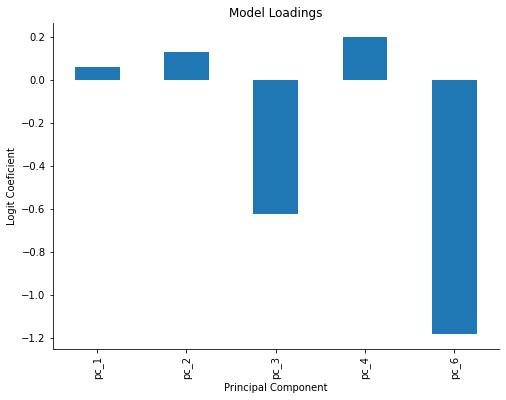

In [44]:
plt.figure(figsize=(8, 6))
feats[feats != 0].plot(kind='bar')
plt.xlabel('Principal Component')
plt.ylabel('Logit Coeficient')
plt.title('Model Loadings')
sns.despine()

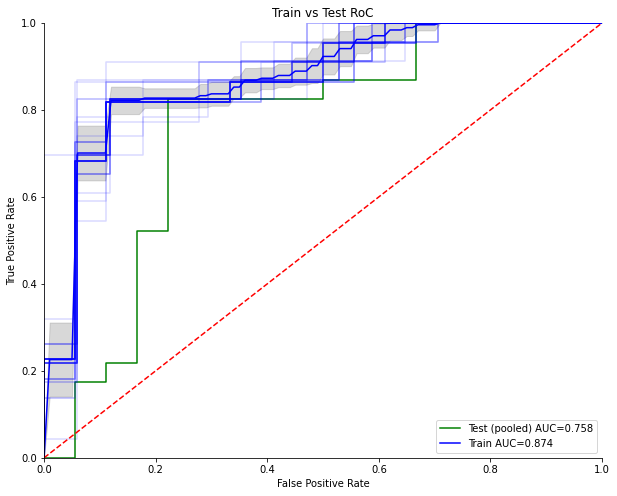

In [32]:
from sklearn.metrics import roc_curve
from scipy import interp

plt.figure(figsize=(10, 8))

y_test_actual = bm.actual.values.reshape(len(bm), 1)
y_test_proba = bm.proba.values.reshape(len(bm), 1)

fpr, tpr, _ = roc_curve(y_test_actual,  y_test_proba)
auc = roc_auc_score(y_test_actual, y_test_proba)
plt.plot(fpr, tpr, color='g', label="Test (pooled) AUC="+str(round(auc, 3)))


actuals = trm.actual
probas = trm.probs

tprs = []
base_fpr = np.linspace(0, 1, 101)
aucs = list()

for actual, proba in zip(actuals, probas):
    fpr, tpr, _ = roc_curve(actual,  proba)
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    aucs.append(roc_auc_score(actual, proba))
                
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b', label="Train AUC="+str(round(np.mean(aucs), 3)))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.legend(loc=4)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train vs Test RoC')

sns.despine()

plt.savefig('/home/pdaly/images/pca-l1_train-test_roc.pdf', transparent=True)